# Car Insurance: Predicting Crash Risk for prospective customers

## Story          
* We are CTO of a highly innovative Car Insurance Company
* Different from other insurance companies we determine the rate by the actual number of accidents per customer
* _Objective: how many accidents will prospective customers have?_ 
* We train a TensorFlow model from known data and use that model to make a prediction for prospective customers

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.6.0'

In [2]:
tf.random.set_seed(42)

In [3]:
# notebook does not need GPU, but we could turn it on any time
!nvidia-smi

Thu Nov 11 12:11:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.50       Driver Version: 471.21       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   43C    P8    14W /  N/A |  14574MiB / 16384MiB |    ERR!      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import numpy as np
np.__version__

'1.19.5'

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

In [6]:
!pip install -q dtreeviz

In [7]:
import dtreeviz
dtreeviz.__version__

'1.3'

In [8]:
# https://github.com/AndreasMadsen/python-lrcurve
!pip install -q lrcurve

In [9]:
from lrcurve import KerasLearningCurve

In [10]:
from dtreeviz import clfviz

def plot_decision_boundaries(model, X, y_true):
  _, ax = plt.subplots(figsize=(8,4), dpi=300)

  clfviz(
              model, X, y_true, 
             show=['instances', 'boundaries', 'probabilities', 'misclassified'],
             markers=['v', '^', 'd'],
             ntiles=50, 
             ax=ax,
             tile_fraction=1.0, 
             boundary_markersize=1.0,
             feature_names=["Age", "Max Speed"],
             colors={'class_boundary': 'black',
                     'tile_alpha': 0.5,
                    #  'warning' : 'yellow',
                     'classes':
                         [None,  # 0 classes
                          None,  # 1 class
                          None,  # 2 classes
                          ['#FF8080', '#FFFF80', '#8080FF'],  # 3 classes
                          ]
                     }
               )

# Step 1: Loading and exploring our data set

https://colab.research.google.com/github/embarced/notebooks/blob/master/mlops/generate.ipynb?hl=en

This is a database of customers of an insurance company. Each data point is one customer. Risk is expressed as a number between 0 and 1. 1 meaning highest and 0 meaning lowerst risk of having an accident.

In [11]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/embarced/notebooks/master/mlops/insurance-customers-risk-1500.csv')
df.head()

,speed,age,miles,group,risk
0,97.0,44.0,30.0,1,0.597611
1,135.0,63.0,29.0,1,0.452710
2,111.0,26.0,34.0,0,0.750234
3,97.0,25.0,10.0,1,0.325249
4,114.0,38.0,22.0,2,0.269731


In [12]:
df.describe()

,speed,age,miles,group,risk
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,122.323333,44.989333,30.384000,0.999333,0.505887
std,17.417147,17.145297,15.214166,0.817177,0.256517
min,80.000000,16.000000,1.000000,0.000000,0.000000
25%,108.000000,32.000000,18.000000,0.000000,0.319750
50%,120.000000,42.000000,29.000000,1.000000,0.502173
75%,137.000000,54.000000,42.000000,2.000000,0.685074
max,166.000000,100.000000,84.000000,2.000000,1.000000


In [13]:
vars = ['speed', 'age', 'miles']

In [14]:
import seaborn as sns

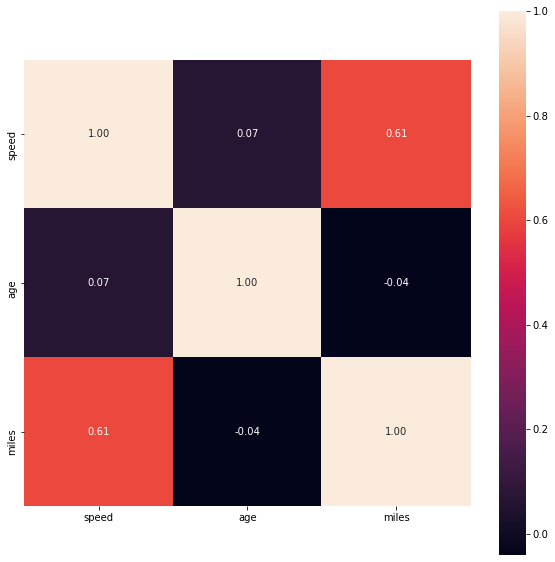

In [15]:
plt.figure(figsize=(10, 10))

cm = df.corr()
cm3 = cm.iloc[:3, :3]

hm = sns.heatmap(cm3,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                yticklabels=vars,
                xticklabels=vars)

# Step 2: Training a neural network on 2 dimensions of the data

In [16]:
y = df['group'].values
# add more columns to list to have fewer features to train on
X = df.drop(['risk', 'group', 'miles'], axis='columns').values
# reorder, first age, then speed to match plotting
X = pd.DataFrame(np.array([X[:, 1], X[:, 0]]).T)
X.shape, y.shape

((1500, 2), (1500,))

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=21)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1200, 2), (300, 2), (1200,), (300,))

In [30]:
from tensorflow.keras.layers import InputLayer, Dense, Dropout, \
                                    BatchNormalization, Activation

num_features = X.shape[1]
dropout = 0.6
model = tf.keras.Sequential()

model.add(InputLayer(name='input', input_shape=(num_features,)))

model.add(Dense(500, name='hidden1'))
model.add(Activation('relu'))
model.add(BatchNormalization())
# model.add(Dropout(dropout))

model.add(Dense(500, name='hidden2'))
model.add(Activation('relu'))
model.add(BatchNormalization())
# model.add(Dropout(dropout))

model.add(Dense(500, name='hidden3'))
model.add(Activation('relu'))
model.add(BatchNormalization())
# model.add(Dropout(dropout))

model.add(Dense(name='output', units=3, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 500)               1500      
_________________________________________________________________
activation_3 (Activation)    (None, 500)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 500)               2000      
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 500)               250500    
_________________________________________________________________
activation_4 (Activation)    (None, 500)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 500)              

In [31]:
%%time 

BATCH_SIZE = 32
EPOCHS = 50

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 12.9 s, sys: 6.43 s, total: 19.3 s
Wall time: 12.2 s


In [32]:
train_loss, train_metric = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_metric

38/38 [==============================] - 0s 2ms/step - loss: 0.7427 - accuracy: 0.6825


(0.7426727414131165, 0.6825000047683716)

In [33]:
test_loss, test_metric = model.evaluate(X_val, y_val, batch_size=BATCH_SIZE)
test_loss, test_metric

10/10 [==============================] - 0s 2ms/step - loss: 0.8076 - accuracy: 0.6700


(0.8076278567314148, 0.6700000166893005)

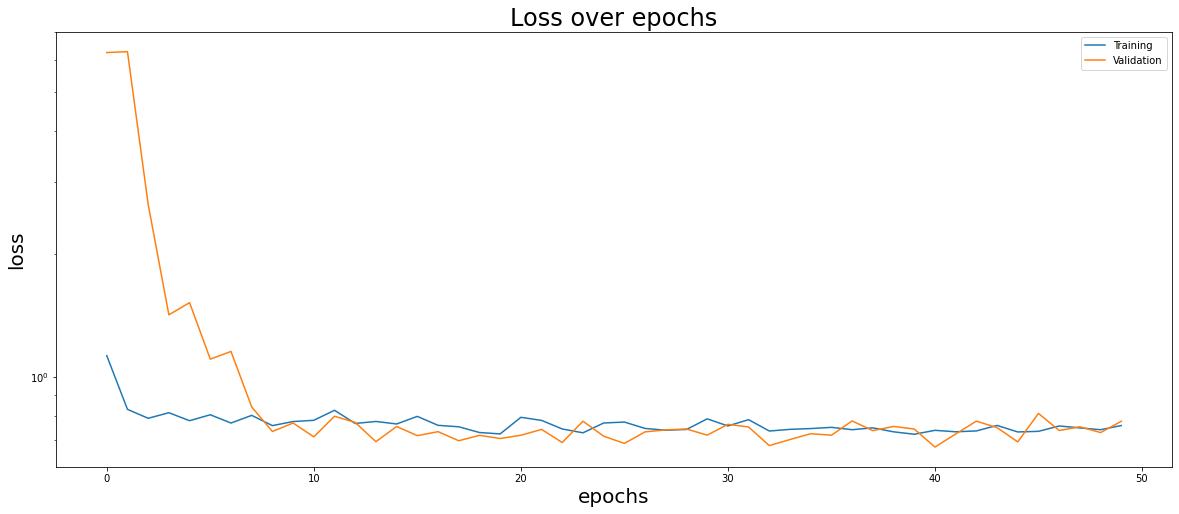

In [23]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over epochs')

plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);

plt.legend(['Training', 'Validation']);

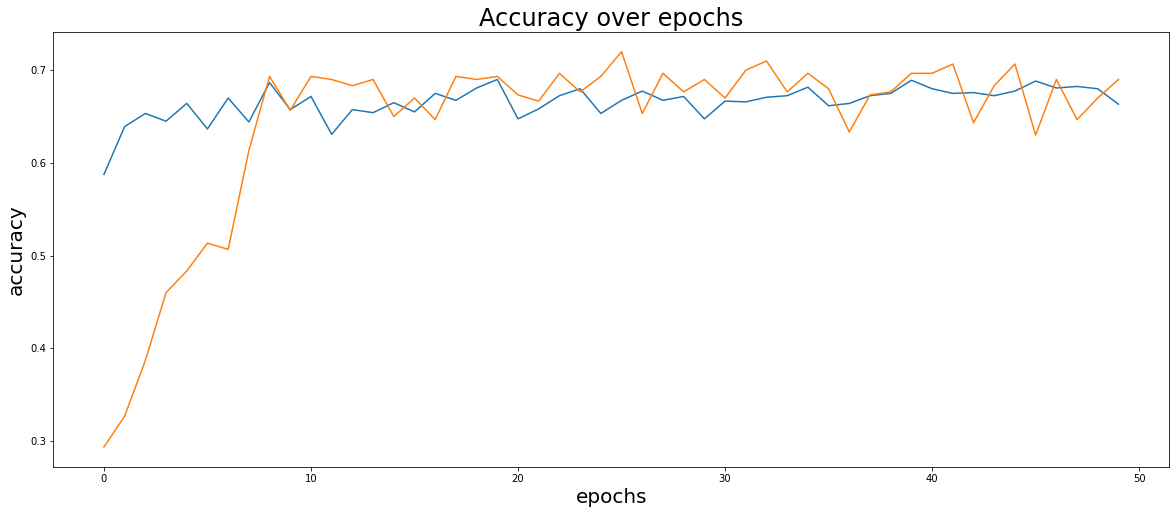

In [24]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over epochs')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [25]:
model.predict([[48, 100]])

array([[0.04415252, 0.28878245, 0.6670651 ]], dtype=float32)

In [26]:
model.predict([[48, 100]]).argmax()

2

In [27]:
model.predict([[30, 150]])

array([[0.9533679 , 0.04145709, 0.00517494]], dtype=float32)

In [28]:
model.predict([[30, 150]]).argmax()

0

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


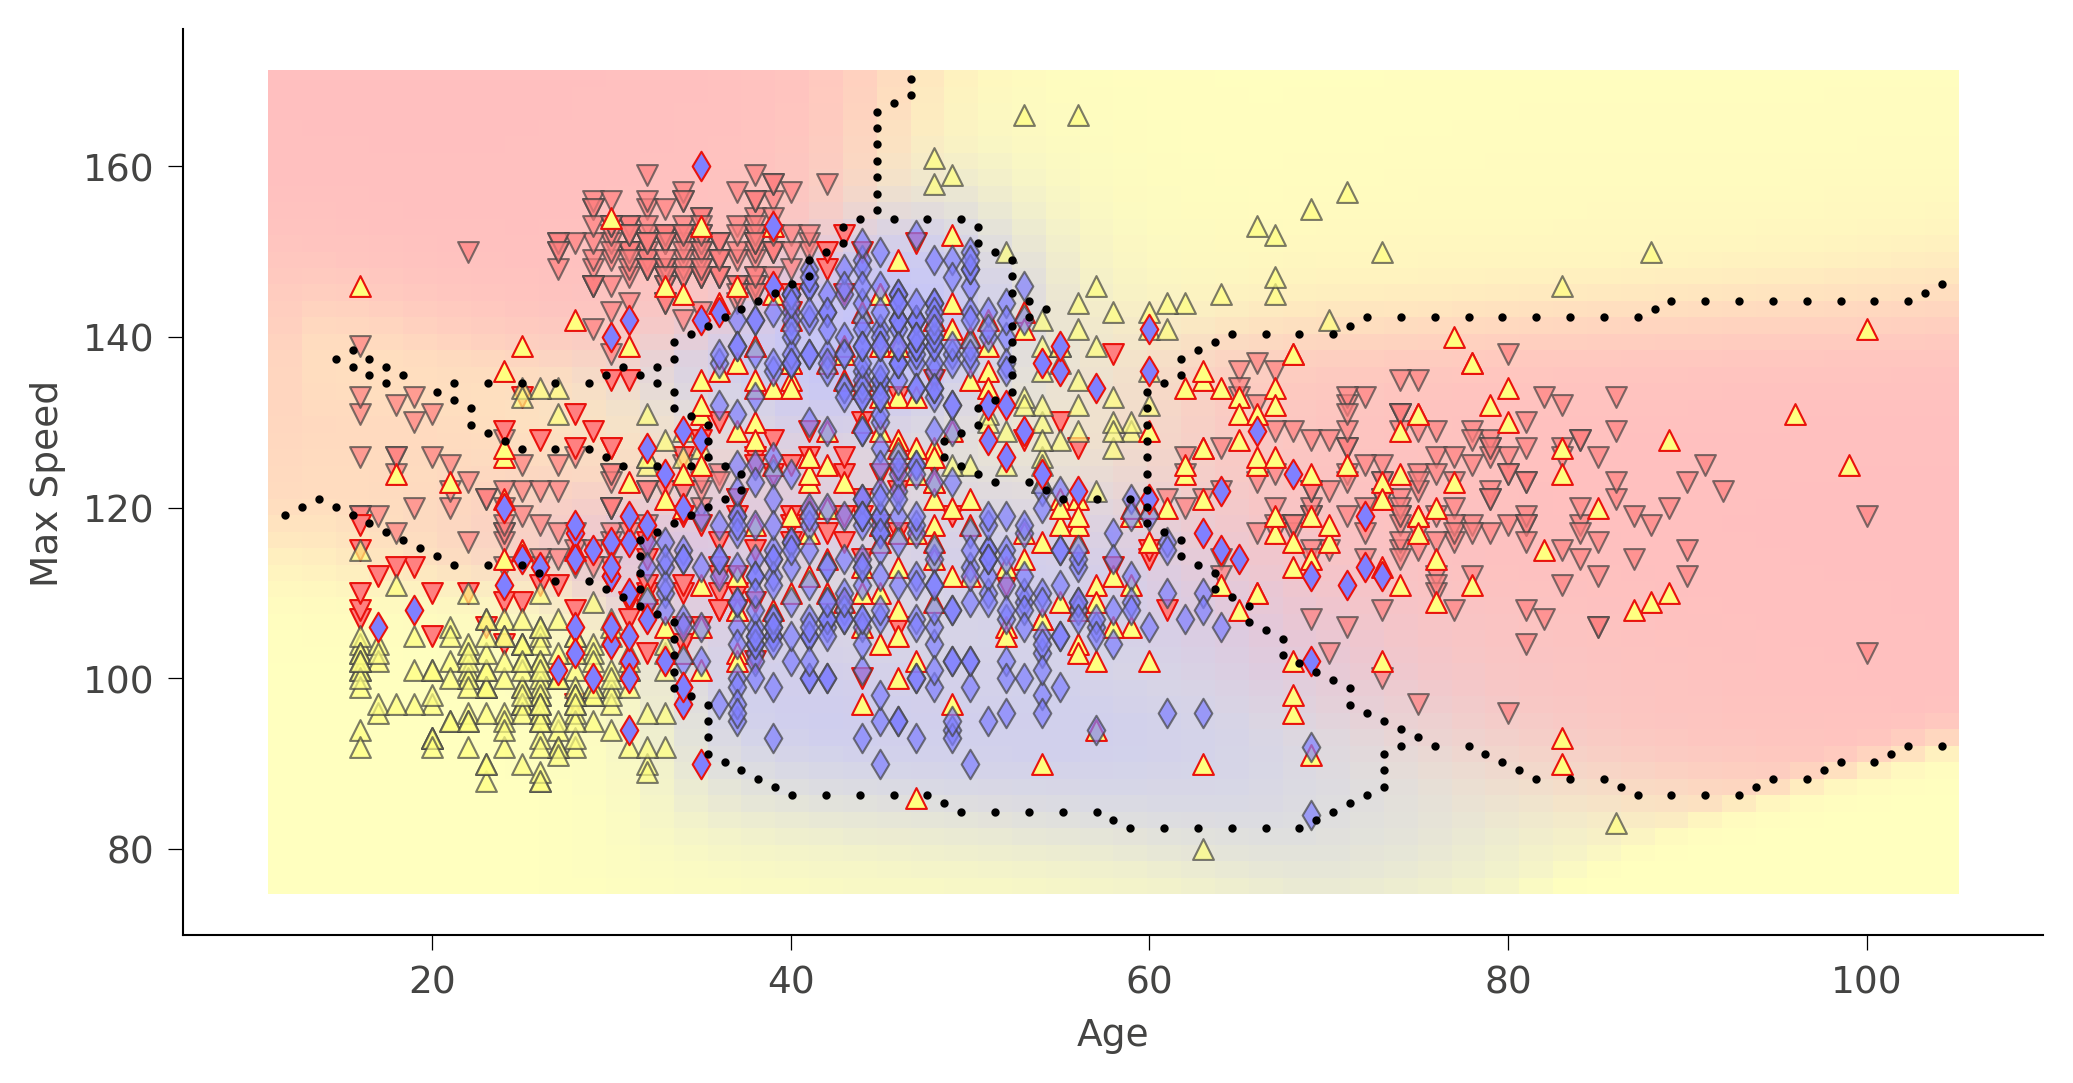

In [29]:
# needs merge of PR
# plot_decision_boundaries(model, X, y, x1_range=(10, 150), x2_range=(50, 250))
plot_decision_boundaries(model, X, y)

In [30]:
# model.save?

In [34]:
model.save('classifier.h5', save_format='h5')

In [35]:
model.save('classifier', save_format='tf')

INFO:tensorflow:Assets written to: classifier/assets


In [36]:
!ls -l

total 21888
-rw-r--r--  1 olli olli 1398200 Nov 11 12:20 1_mlops_train.ipynb
-rw-r--r--  1 olli olli 1819071 Oct 28 14:03 1_mlops_train_nsl.ipynb
-rw-r--r--  1 olli olli  223174 Nov 11 11:26 2_mlops_serve.ipynb
-rw-r--r--  1 olli olli 1695449 Nov  6 11:39 3_mlops_shift.ipynb
-rw-r--r--  1 olli olli   30298 Nov 11 11:44 4_mlops_tfx_training.ipynb
-rw-r--r--  1 olli olli   43870 Nov  7 12:46 5_mlops_tfdv_skew.ipynb
drwxr-xr-x  2 olli olli    4096 Nov 11 11:29 __pycache__
drwxr-xr-x  4 olli olli    4096 Nov 11 12:23 classifier
drwxr-xr-x  4 olli olli    4096 Nov  5 14:01 classifier-pruned
-rw-r--r--  1 olli olli 1207767 Nov  5 14:03 classifier-pruned.tgz
-rw-r--r--  1 olli olli 6169808 Nov 11 12:23 classifier.h5
-rw-r--r--  1 olli olli 5714201 Nov  5 12:24 classifier.tgz
drwxr-xr-x  2 olli olli    4096 Oct 27 16:09 data
drwxr-xr-x  2 olli olli    4096 Oct 27 16:12 drifted_data
-rw-r--r--  1 olli olli 2101066 Nov  7 12:01 generate.ipynb
drwxr-xr-x  3 olli olli    4096 Oct 24 18:42 insuranc

In [37]:
!ls -l classifier/

total 344
drwxr-xr-x 2 olli olli   4096 Oct 24 17:34 assets
-rw-r--r-- 1 olli olli  21244 Nov 11 12:23 keras_metadata.pb
-rw-r--r-- 1 olli olli 318798 Nov 11 12:23 saved_model.pb
drwxr-xr-x 2 olli olli   4096 Nov 11 12:23 variables


In [38]:
!tar czvf classifier.tgz classifier/

classifier/
classifier/keras_metadata.pb
classifier/saved_model.pb
classifier/assets/
classifier/variables/
classifier/variables/variables.index
classifier/variables/variables.data-00000-of-00001


In [36]:
!ls -l

total 19244
-rw-r--r--  1 olli olli   43408 Nov  5 12:23 1_mlops_train.ipynb
-rw-r--r--  1 olli olli 1819071 Oct 28 14:03 1_mlops_train_nsl.ipynb
-rw-r--r--  1 olli olli  175864 Oct 28 14:03 2_mlops_serve.ipynb
-rw-r--r--  1 olli olli 1687116 Oct 28 14:03 3_mlops_shift.ipynb
-rw-r--r--  1 olli olli   47506 Nov  2 14:48 4_mlops_tfx_training.ipynb
drwxr-xr-x  2 olli olli    4096 Nov  2 11:22 __pycache__
drwxr-xr-x  4 olli olli    4096 Nov  5 12:24 classifier
-rw-r--r--  1 olli olli 6166768 Nov  5 12:24 classifier.h5
-rw-r--r--  1 olli olli 5714201 Nov  5 12:24 classifier.tgz
drwxr-xr-x  2 olli olli    4096 Oct 27 16:09 data
drwxr-xr-x  2 olli olli    4096 Oct 27 16:12 drifted_data
-rw-r--r--  1 olli olli 2110237 Aug 14 20:29 generate.ipynb
drwxr-xr-x  3 olli olli    4096 Oct 24 18:42 insurance
-rw-r--r--  1 olli olli   54500 Aug 14 20:29 insurance-customers-risk-1500-shift.csv
-rw-r--r--  1 olli olli   54435 Aug 14 20:29 insurance-customers-risk-1500-test.csv
-rw-r--r--  1 olli olli   54